In [1]:
# dependencies
import pandas as pd
import nltk
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn import feature_extraction, model_selection, feature_selection, naive_bayes, \
                    pipeline, metrics
from sklearn.model_selection import train_test_split
from lime import lime_text

stop = stopwords.words('english')

# only need to run once
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [2]:
all_wines = pd.read_csv('Data/winemag-data-130k-v2.csv')
all_wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
clean_wines = all_wines.drop(columns=['Unnamed: 0', 'taster_twitter_handle', 'region_2', 'price', 'province',
                                     'region_1', 'taster_name', 'title', 'variety', 'winery', 'country', 'designation'])
clean_wines = clean_wines.dropna()
clean_wines

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90
129967,Citation is given as much as a decade of bottl...,90
129968,Well-drained gravel soil gives this wine its c...,90
129969,"A dry style of Pinot Gris, this is crisp with ...",90


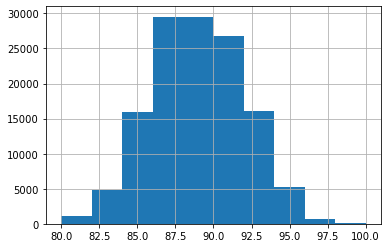

In [4]:
clean_wines['points'].hist()

In [5]:
clean_wines['points'].describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [6]:
clean_wines = clean_wines.drop_duplicates('description')
clean_wines 

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90
129967,Citation is given as much as a decade of bottl...,90
129968,Well-drained gravel soil gives this wine its c...,90
129969,"A dry style of Pinot Gris, this is crisp with ...",90


In [7]:
clean_wines['grade'] = clean_wines['points'].apply(lambda x: 'A' if x >= 92 else
                                                             'B' if x >= 89 else
                                                             'C' if x >= 86 else
                                                             'F')
clean_wines

C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,description,points,grade
0,"Aromas include tropical fruit, broom, brimston...",87,C
1,"This is ripe and fruity, a wine that is smooth...",87,C
2,"Tart and snappy, the flavors of lime flesh and...",87,C
3,"Pineapple rind, lemon pith and orange blossom ...",87,C
4,"Much like the regular bottling from 2012, this...",87,C
...,...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,B
129967,Citation is given as much as a decade of bottl...,90,B
129968,Well-drained gravel soil gives this wine its c...,90,B
129969,"A dry style of Pinot Gris, this is crisp with ...",90,B


In [8]:
clean_wines['good_bad'] = clean_wines['points'].apply(lambda x: 'Good' if x >= 88 else
                                                     'Bad')
clean_wines

C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,description,points,grade,good_bad
0,"Aromas include tropical fruit, broom, brimston...",87,C,Bad
1,"This is ripe and fruity, a wine that is smooth...",87,C,Bad
2,"Tart and snappy, the flavors of lime flesh and...",87,C,Bad
3,"Pineapple rind, lemon pith and orange blossom ...",87,C,Bad
4,"Much like the regular bottling from 2012, this...",87,C,Bad
...,...,...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,B,Good
129967,Citation is given as much as a decade of bottl...,90,B,Good
129968,Well-drained gravel soil gives this wine its c...,90,B,Good
129969,"A dry style of Pinot Gris, this is crisp with ...",90,B,Good


In [9]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [10]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
clean_wines["description_clean"] = clean_wines["description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
clean_wines.head()

C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,description,points,grade,good_bad,description_clean
0,"Aromas include tropical fruit, broom, brimston...",87,C,Bad,aroma include tropical fruit broom brimstone d...
1,"This is ripe and fruity, a wine that is smooth...",87,C,Bad,ripe fruity wine smooth still structured firm ...
2,"Tart and snappy, the flavors of lime flesh and...",87,C,Bad,tart snappy flavor lime flesh rind dominate gr...
3,"Pineapple rind, lemon pith and orange blossom ...",87,C,Bad,pineapple rind lemon pith orange blossom start...
4,"Much like the regular bottling from 2012, this...",87,C,Bad,much like regular bottling 2012 come across ra...


In [12]:
list_of_texts = clean_wines['description_clean']
def no_number_preprocessor(tokens):
    r = re.sub('(\d)+', '', tokens.lower())
    # This alternative just removes numbers:
    # r = re.sub('(\d)+', '', tokens.lower())
    return r
no_num_txts = []
for t in list_of_texts:
    no_num_t = no_number_preprocessor(t)
    no_num_txts.append(no_num_t)

clean_wines['description_cleaner'] = no_num_txts
clean_wines

C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,description,points,grade,good_bad,description_clean,description_cleaner
0,"Aromas include tropical fruit, broom, brimston...",87,C,Bad,aroma include tropical fruit broom brimstone d...,aroma include tropical fruit broom brimstone d...
1,"This is ripe and fruity, a wine that is smooth...",87,C,Bad,ripe fruity wine smooth still structured firm ...,ripe fruity wine smooth still structured firm ...
2,"Tart and snappy, the flavors of lime flesh and...",87,C,Bad,tart snappy flavor lime flesh rind dominate gr...,tart snappy flavor lime flesh rind dominate gr...
3,"Pineapple rind, lemon pith and orange blossom ...",87,C,Bad,pineapple rind lemon pith orange blossom start...,pineapple rind lemon pith orange blossom start...
4,"Much like the regular bottling from 2012, this...",87,C,Bad,much like regular bottling 2012 come across ra...,much like regular bottling come across rather...
...,...,...,...,...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,B,Good,note honeysuckle cantaloupe sweeten deliciousl...,note honeysuckle cantaloupe sweeten deliciousl...
129967,Citation is given as much as a decade of bottl...,90,B,Good,citation given much decade bottle age prior re...,citation given much decade bottle age prior re...
129968,Well-drained gravel soil gives this wine its c...,90,B,Good,welldrained gravel soil give wine crisp dry ch...,welldrained gravel soil give wine crisp dry ch...
129969,"A dry style of Pinot Gris, this is crisp with ...",90,B,Good,dry style pinot gris crisp acidity also weight...,dry style pinot gris crisp acidity also weight...


In [13]:
list_of_descriptions = clean_wines['description_cleaner']
adjs = []
for t in list_of_descriptions:
    is_adj = lambda pos: pos[:2] == 'JJ'
    tokenized = nltk.word_tokenize(t)
    adj = [word for (word, pos) in nltk.pos_tag(tokenized) if is_adj(pos)]
    adjs.append(adj)

In [14]:
all_adj_string_list = []
for x in adjs:
    all_adj_string = ""
    for y in x:
        all_adj_string = all_adj_string + " " + y
    
    all_adj_string_list.append(all_adj_string)
    
all_adj_string_list

[' tropical herb expressive unripened brisk',
 ' ripe firm red drinkable better',
 ' snappy flesh green crisp flavor',
 ' blossom opulent guava astringent',
 ' much regular rough tannic rustic herbal characteristic unfussy good',
 ' typical green horseradish full tomatoey herbal finish fresh',
 ' bright informal red open berry white fresh soft',
 ' dry',
 ' thyme sunnier offdry fresh',
 ' great depth fresh touch',
 ' soft oaky merlot complete strong valuepriced attractive immediate',
 ' dry taut mineral crisp',
 ' tannic rich black',
 ' oakdriven coffee plum tannin abrupt',
 ' leaner classic tart green good everyday ripe approachable',
 ' zesty dry racy lean easy wide',
 ' balsamic bolt accent green respectable',
 ' raw direct good thickens oak apparent oak finish hot',
 ' tannic woodspice',
 ' red nose open crushed approachable ready',
 ' ripe mingle ample black oakdriven nature currant',
 ' sleek fair available pinot neutral indicated',
 ' delicate white lime white mineral bright',
 

In [15]:
clean_wines['adjectives'] = all_adj_string_list
clean_wines

C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,description,points,grade,good_bad,description_clean,description_cleaner,adjectives
0,"Aromas include tropical fruit, broom, brimston...",87,C,Bad,aroma include tropical fruit broom brimstone d...,aroma include tropical fruit broom brimstone d...,tropical herb expressive unripened brisk
1,"This is ripe and fruity, a wine that is smooth...",87,C,Bad,ripe fruity wine smooth still structured firm ...,ripe fruity wine smooth still structured firm ...,ripe firm red drinkable better
2,"Tart and snappy, the flavors of lime flesh and...",87,C,Bad,tart snappy flavor lime flesh rind dominate gr...,tart snappy flavor lime flesh rind dominate gr...,snappy flesh green crisp flavor
3,"Pineapple rind, lemon pith and orange blossom ...",87,C,Bad,pineapple rind lemon pith orange blossom start...,pineapple rind lemon pith orange blossom start...,blossom opulent guava astringent
4,"Much like the regular bottling from 2012, this...",87,C,Bad,much like regular bottling 2012 come across ra...,much like regular bottling come across rather...,much regular rough tannic rustic herbal chara...
...,...,...,...,...,...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,B,Good,note honeysuckle cantaloupe sweeten deliciousl...,note honeysuckle cantaloupe sweeten deliciousl...,featherlight spätlese palate wrap kiss
129967,Citation is given as much as a decade of bottl...,90,B,Good,citation given much decade bottle age prior re...,citation given much decade bottle age prior re...,prior cherry soft secondary
129968,Well-drained gravel soil gives this wine its c...,90,B,Good,welldrained gravel soil give wine crisp dry ch...,welldrained gravel soil give wine crisp dry ch...,gravel dry serious couple
129969,"A dry style of Pinot Gris, this is crisp with ...",90,B,Good,dry style pinot gris crisp acidity also weight...,dry style pinot gris crisp acidity also weight...,dry solid powerful wine


In [16]:
dtf = clean_wines[['points', 'grade', 'good_bad', 'description_clean', 'description_cleaner', 'adjectives']]
dtf

,points,grade,good_bad,description_clean,description_cleaner,adjectives
0,87,C,Bad,aroma include tropical fruit broom brimstone d...,aroma include tropical fruit broom brimstone d...,tropical herb expressive unripened brisk
1,87,C,Bad,ripe fruity wine smooth still structured firm ...,ripe fruity wine smooth still structured firm ...,ripe firm red drinkable better
2,87,C,Bad,tart snappy flavor lime flesh rind dominate gr...,tart snappy flavor lime flesh rind dominate gr...,snappy flesh green crisp flavor
3,87,C,Bad,pineapple rind lemon pith orange blossom start...,pineapple rind lemon pith orange blossom start...,blossom opulent guava astringent
4,87,C,Bad,much like regular bottling 2012 come across ra...,much like regular bottling come across rather...,much regular rough tannic rustic herbal chara...
...,...,...,...,...,...,...
129966,90,B,Good,note honeysuckle cantaloupe sweeten deliciousl...,note honeysuckle cantaloupe sweeten deliciousl...,featherlight spätlese palate wrap kiss
129967,90,B,Good,citation given much decade bottle age prior re...,citation given much decade bottle age prior re...,prior cherry soft secondary
129968,90,B,Good,welldrained gravel soil give wine crisp dry ch...,welldrained gravel soil give wine crisp dry ch...,gravel dry serious couple
129969,90,B,Good,dry style pinot gris crisp acidity also weight...,dry style pinot gris crisp acidity also weight...,dry solid powerful wine


In [17]:
dtf.to_csv('Data/clean_wines_with_adjectives.csv')

In [18]:
dtf = pd.read_csv('Data/clean_wines_with_adjectives.csv')
dtf

,Unnamed: 0,points,grade,good_bad,description_clean,description_cleaner,adjectives
0,0,87,C,Bad,aroma include tropical fruit broom brimstone d...,aroma include tropical fruit broom brimstone d...,tropical herb expressive unripened brisk
1,1,87,C,Bad,ripe fruity wine smooth still structured firm ...,ripe fruity wine smooth still structured firm ...,ripe firm red drinkable better
2,2,87,C,Bad,tart snappy flavor lime flesh rind dominate gr...,tart snappy flavor lime flesh rind dominate gr...,snappy flesh green crisp flavor
3,3,87,C,Bad,pineapple rind lemon pith orange blossom start...,pineapple rind lemon pith orange blossom start...,blossom opulent guava astringent
4,4,87,C,Bad,much like regular bottling 2012 come across ra...,much like regular bottling come across rather...,much regular rough tannic rustic herbal chara...
...,...,...,...,...,...,...,...
119950,129966,90,B,Good,note honeysuckle cantaloupe sweeten deliciousl...,note honeysuckle cantaloupe sweeten deliciousl...,featherlight spätlese palate wrap kiss
119951,129967,90,B,Good,citation given much decade bottle age prior re...,citation given much decade bottle age prior re...,prior cherry soft secondary
119952,129968,90,B,Good,welldrained gravel soil give wine crisp dry ch...,welldrained gravel soil give wine crisp dry ch...,gravel dry serious couple
119953,129969,90,B,Good,dry style pinot gris crisp acidity also weight...,dry style pinot gris crisp acidity also weight...,dry solid powerful wine


In [19]:
dtf.dropna()
dtf

,Unnamed: 0,points,grade,good_bad,description_clean,description_cleaner,adjectives
0,0,87,C,Bad,aroma include tropical fruit broom brimstone d...,aroma include tropical fruit broom brimstone d...,tropical herb expressive unripened brisk
1,1,87,C,Bad,ripe fruity wine smooth still structured firm ...,ripe fruity wine smooth still structured firm ...,ripe firm red drinkable better
2,2,87,C,Bad,tart snappy flavor lime flesh rind dominate gr...,tart snappy flavor lime flesh rind dominate gr...,snappy flesh green crisp flavor
3,3,87,C,Bad,pineapple rind lemon pith orange blossom start...,pineapple rind lemon pith orange blossom start...,blossom opulent guava astringent
4,4,87,C,Bad,much like regular bottling 2012 come across ra...,much like regular bottling come across rather...,much regular rough tannic rustic herbal chara...
...,...,...,...,...,...,...,...
119950,129966,90,B,Good,note honeysuckle cantaloupe sweeten deliciousl...,note honeysuckle cantaloupe sweeten deliciousl...,featherlight spätlese palate wrap kiss
119951,129967,90,B,Good,citation given much decade bottle age prior re...,citation given much decade bottle age prior re...,prior cherry soft secondary
119952,129968,90,B,Good,welldrained gravel soil give wine crisp dry ch...,welldrained gravel soil give wine crisp dry ch...,gravel dry serious couple
119953,129969,90,B,Good,dry style pinot gris crisp acidity also weight...,dry style pinot gris crisp acidity also weight...,dry solid powerful wine


In [20]:
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["good_bad"].values
y_test = dtf_test["good_bad"].values

In [21]:
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

In [22]:
corpus = dtf_train["description_cleaner"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [24]:
y = dtf_train["good_bad"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "good_bad":cat}))
    dtf_features = dtf_features.sort_values(["good_bad","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [25]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["good_bad"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["good_bad"]==cat]["feature"].values[:30]))
   print(" ")

# Bad:
  . selected features: 6181
  . top features: acidic,add,age,age drink,age well,age year,aged,ageworthy,aging,aging drink,aging potential,alluring,alongside,alongside firm,alpine,already,also,among,anise,another,appellation,appetizing,aromatic,around,asparagus,astringent,astringent tannin,attractive,awkward,backbone
 
# Good:
  . selected features: 6181
  . top features: acidic,add,age,age drink,age well,age year,aged,ageworthy,aging,aging drink,aging potential,alluring,alongside,alongside firm,alpine,already,also,among,anise,another,appellation,appetizing,aromatic,around,asparagus,astringent,astringent tannin,attractive,awkward,backbone
 


In [26]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [27]:
classifier = naive_bayes.MultinomialNB()

In [28]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["description_cleaner"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [29]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
y_test_array

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]], dtype=uint8)

In [30]:
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="one_vs_one")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.8
Auc: 0.88
Detail:
              precision    recall  f1-score   support

         Bad       0.81      0.64      0.72     14389
        Good       0.79      0.90      0.84     21598

    accuracy                           0.80     35987
   macro avg       0.80      0.77      0.78     35987
weighted avg       0.80      0.80      0.79     35987



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

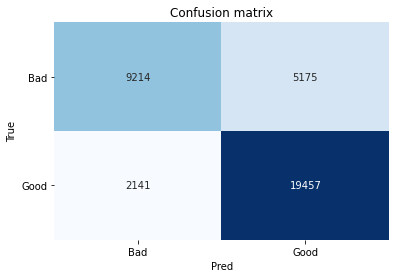

In [31]:
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


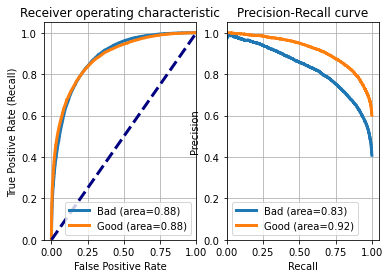

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [33]:
## select observation
i = 17
txt_instance = dtf_test["description_cleaner"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=5)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Bad --> Pred: Bad | Prob: 0.85


C:\Users\Rahil\anaconda3\lib\site-packages\lime\lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [34]:
d = {'prediction' : predicted, 
     'actual' : y_test}

In [35]:
text_predictions_df = pd.DataFrame(data=d)
text_predictions_df

,prediction,actual
0,Good,Bad
1,Good,Good
2,Good,Good
3,Good,Bad
4,Good,Good
...,...,...
35982,Good,Bad
35983,Good,Bad
35984,Bad,Bad
35985,Good,Good


In [36]:
text_predictions_df.to_csv('Data/text_predictions_binary.csv')

In [37]:
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["grade"].values
y_test = dtf_test["grade"].values

In [38]:
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

In [39]:
corpus = dtf_train["description_cleaner"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [41]:
y = dtf_train["grade"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "grade":cat}))
    dtf_features = dtf_features.sort_values(["grade","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [42]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["grade"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["grade"]==cat]["feature"].values[:30]))
   print(" ")

# A:
  . selected features: 5293
  . top features: absolutely,age,age drink,age least,age many,age well,ageworthy,ageworthy wine,aging,aging drink,aging potential,alluring,alluring aroma,already,also,always,amazing,amazingly,among,anise,another,another decade,appellation,apple,aroma,aroma youll,aromatic,around,astringent,attractive
 
# B:
  . selected features: 3528
  . top features: aging,appetizing,baking,baking spice,balance,balanced,barrel,basic,bit,bitter,black,black cherry,blackberry,blend,cabernet,cabernet sauvignon,cassis,cherry,chocolate,complex,concentrated,dark,delicious,dense,drink now,easy,easygoing,elegant,everyday,excellent
 
# C:
  . selected features: 3945
  . top features: age,age well,ageworthy,aging,apple,aroma,astringent,astringent tannin,attractive,balance,barolo,barrel sample,beautiful,beautifully,beauty,best,bit,bitter almond,black,blackberry,bottling,bright,brooding,cabernet,cassis,cellar,chocolate,cinnamon,citrus,clean
 
# F:
  . selected features: 5712
  . to

In [43]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [44]:
classifier = naive_bayes.MultinomialNB()

In [45]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["description_cleaner"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [46]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
y_test_array

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]], dtype=uint8)

In [47]:
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="one_vs_rest")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.54
Auc: 0.81
Detail:
              precision    recall  f1-score   support

           A       0.69      0.32      0.44      6233
           B       0.48      0.55      0.51     10787
           C       0.53      0.73      0.61     12675
           F       0.77      0.38      0.51      6292

    accuracy                           0.54     35987
   macro avg       0.62      0.50      0.52     35987
weighted avg       0.58      0.54      0.53     35987



(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

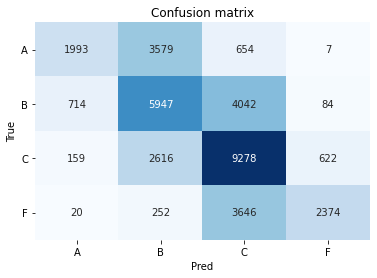

In [48]:
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


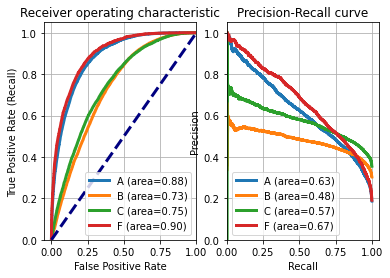

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [50]:
## select observation
i = 5
txt_instance = dtf_test["description_cleaner"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=5)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: C --> Pred: C | Prob: 0.56


C:\Users\Rahil\anaconda3\lib\site-packages\lime\lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [51]:
d = {'prediction' : predicted, 
     'actual' : y_test}

In [52]:
text_predictions_df = pd.DataFrame(data=d)
text_predictions_df

,prediction,actual
0,C,B
1,B,B
2,B,B
3,F,F
4,C,C
...,...,...
35982,C,B
35983,B,B
35984,C,A
35985,C,B


In [53]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, predicted)

0.35536344012802057

In [54]:
text_predictions_df.to_csv('Data/text_predictions_grades.csv')